<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span><strong>Вывод</strong></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
data.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [ ]:
# меняем тип данных Datetime с object на datetime64
# устанавливаем индекс таблицы равным столбцу Datetime
# сортируем по индексам
# проверяем временной ряд на монотонность
data = data.astype({'datetime':'datetime64'})
data = data.set_index('datetime')
data = data.sort_index(ascending = True)
print(data.index.is_monotonic)

True


In [ ]:
# ресемплируем по одному часу
data = data.resample('1H').sum()

## Анализ

In [ ]:
data_analis = data.copy()

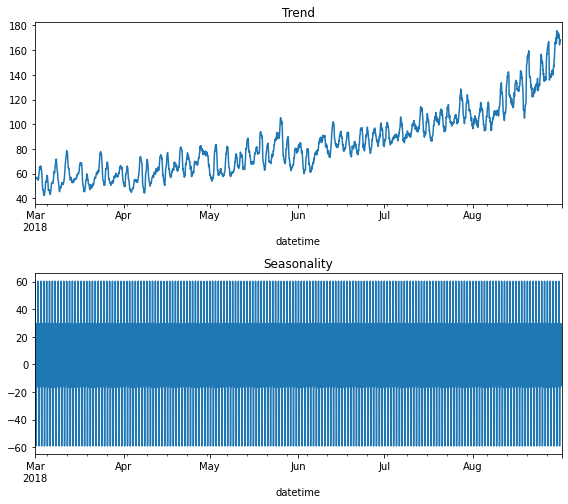

In [ ]:
# строим тренды и сезонность
decomposed = seasonal_decompose(data_analis)
plt.figure(figsize=(8,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
# plt.subplot(313)
# decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
# plt.title('Residuals')
plt.tight_layout()

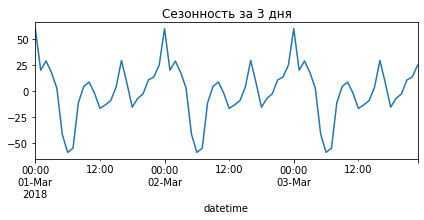

In [ ]:
# изучаем приближенно сезонность на днях
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Сезонность за 3 дня')
plt.tight_layout()

In [ ]:
# ресемплируем по одному дню
data_day = data.resample('1D').sum()

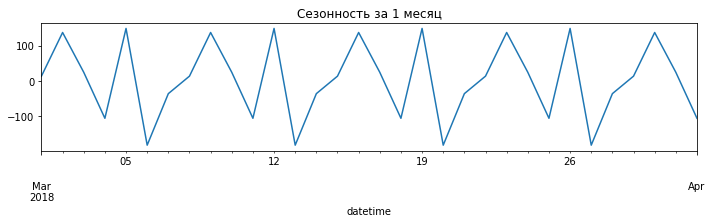

In [ ]:
# строим тренды и сезонность
decomposed = seasonal_decompose(data_day)
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Сезонность за 1 месяц')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

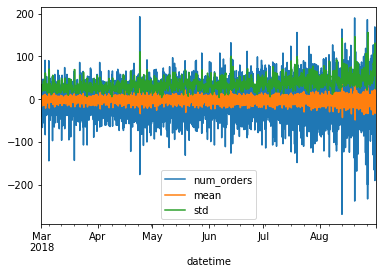

In [ ]:
# для прогнозирования ряды должны быть стационарными,
# Стохастический процесс стационарный, если его распределение со временем не меняется.
# сделаем верменной ряд стационарным,  через набор разностей между соседними элементами временного ряда
data_analis = data_analis - data_analis.shift()


data_analis['mean'] = data_analis['num_orders'].rolling(7).mean()
data_analis['std'] = data_analis['num_orders'].rolling(7).std()
data_analis.plot()

In [ ]:
data_analis.head()

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN


Создадим признаки для горизонта прогнозирования в один день. Так как тренды и сезонность привязаны к конкретной дате, представим нужную инормацию как отдельные столбцы: согласно диаграмме трендов количество вызовов такси зависит от месяца, дня и часа. Создаем календарные признаки месяца, дня и часа. А также формируем "отстающие значения", это может определить функция x(t) будет расти или уменьшаться.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data, 8, 24)

In [ ]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN


## Обучение

In [ ]:
#создаем таблицу выходных значений
table_of_rmse=[]
table_of_model=[]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   dayofweek     4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  rolling_mean  4392 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 448.5 KB


In [ ]:
# делим выборкуна train и test в размере 10%
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'],axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [ ]:
RANDOM_STATE = 42

In [ ]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Линейная регрессия с регуляризацией**

In [ ]:
model_ridge = Ridge(random_state=RANDOM_STATE)

#словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}
tscv = TimeSeriesSplit(n_splits=3)
gs_ridge = GridSearchCV(
    model_ridge,
    cv = tscv,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_ridge.fit(features_train, target_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge.best_score_* -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score: 32.77286782890868
best_params: {'alpha': 0.2}


In [ ]:
table_of_rmse.append(gs_ridge.best_score_* -1)
table_of_model.append('model_ridge')

**RandomForestRegressor**

In [ ]:
param = {
    'n_estimators':[20,30],
    'max_features':[0.3,1]
}
model_rfr = RandomForestRegressor()
gs_rfr = GridSearchCV(
    model_rfr,
    param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

gs_rfr.fit(features_train, target_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_rfr.best_score_* -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_rfr.best_params_}')

best_score: 28.27999714792645
best_params: {'max_features': 0.3, 'n_estimators': 30}


In [ ]:
table_of_rmse.append(gs_rfr.best_score_* -1)
table_of_model.append(model_rfr)

**Catboost**

In [ ]:
parameter = {'learning_rate': [0.03,0.1],
             'depth': [4,6,8],
             'l2_leaf_reg': [1,2,3]
              }
model_cbr = CatBoostRegressor()

gs_cbr = GridSearchCV(
    estimator = model_cbr,
    param_grid = parameter,
    cv = tscv, n_jobs=-1,
    scoring='neg_root_mean_squared_error')

gs_cbr.fit(features_train, target_train)

0:	learn: 28.8869413	total: 52.6ms	remaining: 52.5s
1:	learn: 28.4803016	total: 53.3ms	remaining: 26.6s
2:	learn: 28.1720896	total: 53.9ms	remaining: 17.9s
3:	learn: 27.8410413	total: 54.5ms	remaining: 13.6s
4:	learn: 27.5144948	total: 55.1ms	remaining: 11s
5:	learn: 27.2098498	total: 55.7ms	remaining: 9.22s
6:	learn: 26.9074739	total: 56.3ms	remaining: 7.98s
7:	learn: 26.7003194	total: 56.8ms	remaining: 7.05s
8:	learn: 26.4591094	total: 57.4ms	remaining: 6.32s
9:	learn: 26.1812074	total: 58ms	remaining: 5.75s
10:	learn: 25.9202807	total: 58.7ms	remaining: 5.27s
11:	learn: 25.6874051	total: 59.2ms	remaining: 4.88s
12:	learn: 25.5271691	total: 59.8ms	remaining: 4.54s
13:	learn: 25.3801297	total: 60.3ms	remaining: 4.25s
14:	learn: 25.2046953	total: 60.9ms	remaining: 4s
15:	learn: 24.9715797	total: 61.4ms	remaining: 3.78s
16:	learn: 24.8163442	total: 62ms	remaining: 3.58s
17:	learn: 24.5649042	total: 62.5ms	remaining: 3.41s
18:	learn: 24.4170584	total: 63.1ms	remaining: 3.26s
19:	learn: 2

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6a106405e0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'l2_leaf_reg': [1, 2, 3],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_cbr.best_score_* -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_cbr.best_params_}')

best_score: 26.733463228538742
best_params: {'depth': 4, 'l2_leaf_reg': 2, 'learning_rate': 0.03}


In [ ]:
table_of_rmse.append(gs_cbr.best_score_* -1)
table_of_model.append('model_cbr')

In [ ]:
models = (pd.DataFrame(
    {'Model':table_of_model,'RMSE':table_of_rmse})
                .sort_values(by='RMSE')
                .set_index('Model'))

models

,RMSE
Model,
model_cbr,26.733463
RandomForestRegressor(),28.279997
model_ridge,32.772868


**Вывод**  
По результатам обучения моделей лучшей оказалась Catboost c результатом метрики качества на train 23,95. Выбираем ее для тестирования.

## Тестирование

In [ ]:
pred = gs_cbr.predict(features_test)
RMSE_final_ = mean_squared_error(target_test, pred) ** 0.5
print('RMSE на тестовой выборке - ', RMSE_final_)

RMSE на тестовой выборке -  45.12904630687686


##### **Вывод**  
1. Загрузили данные и выполнили их ресемплирование по одному часу.
2. Проанализировали данные. Подготовили данные для обучения моделей.
3. Обучили три модели с различными гиперпараметрами. Сделали тестовую выборку размером 10% от исходных данных.
4. Провили данные на тестовой выборке.
5. По результатам обучения моделей лучшей оказалась Catboost c результатом метрики качества на train 26.7. выполнили предсказания на тестовой выборке. Метрика качества работы модели на тестовой выборке получилось 45, что соответствует заявленным требованиям к модели не больше 48.